# Step 1 读取数据集

In [1]:
import os
import glob

def load_imdb_data(data_dir="/kaggle/input/imdbv1/aclImdb", is_train=True):
    """读取IMDb训练集，返回(文本内容, 情感标签)列表"""
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"目录不存在: {data_dir}")
    if is_train:
        data_dir = os.path.join(data_dir, 'train')
    else:
        data_dir = os.path.join(data_dir, 'test')
        
    data = []
    # 遍历正负样本文件夹
    # neg: 0, pos: 1
    for label, folder in enumerate(["neg", "pos"]):
        folder_path = os.path.join(data_dir, folder)
        # 匹配所有txt文件（排除隐藏文件）
        file_pattern = os.path.join(folder_path, "*.txt")
        for file_path in glob.glob(file_pattern):
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    text = f.read().strip()
                    data.append( (text, label) )
            except UnicodeDecodeError:
                print(f"跳过损坏文件: {file_path}")
            except Exception as e:
                print(f"读取错误 {file_path}: {str(e)}")
    return data

In [2]:
data_dir = "/kaggle/input/imdbv1/aclImdb"
# 读取训练集和测试集数据
train_corpus = load_imdb_data(data_dir=data_dir, is_train=True)
test_corpus = load_imdb_data(data_dir=data_dir, is_train=False)

In [3]:
train_corpus[0]

('This film is the worst film, but it ranks very high for me. It is how a slasher movie should be. It takes place at a university in which there only seems to be a handful of students. The teachers are dumber than a sack of hammers. It is filled with good Catholic priest, sexually repressed humor. Bad hair, bad clothes. The dialogue is so cliched it is hard to believe that I was able to predict lines in quotes. The slashings have some creativity and seem to revolve around stabbing people in the genitalia. A lack of continuity in the soundtrack and characters that deserve to die because they are so bad, I recommend this film for a fun time. Get a case of cheap beer and some friends, watch it and laugh.',
 0)

# Step 2 数据预处理

## tokenize

In [4]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize_corpus(corpus):
    tokenized_corpus = []
    for text, label in corpus:
        tokens = word_tokenize(text)
        tokenized_corpus.append((tokens, label))
    return tokenized_corpus

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
tokenized_train_corpus = tokenize_corpus(train_corpus)
tokenized_test_corpus = tokenize_corpus(test_corpus)

In [6]:
tokenized_train_corpus[0]

(['This',
  'film',
  'is',
  'the',
  'worst',
  'film',
  ',',
  'but',
  'it',
  'ranks',
  'very',
  'high',
  'for',
  'me',
  '.',
  'It',
  'is',
  'how',
  'a',
  'slasher',
  'movie',
  'should',
  'be',
  '.',
  'It',
  'takes',
  'place',
  'at',
  'a',
  'university',
  'in',
  'which',
  'there',
  'only',
  'seems',
  'to',
  'be',
  'a',
  'handful',
  'of',
  'students',
  '.',
  'The',
  'teachers',
  'are',
  'dumber',
  'than',
  'a',
  'sack',
  'of',
  'hammers',
  '.',
  'It',
  'is',
  'filled',
  'with',
  'good',
  'Catholic',
  'priest',
  ',',
  'sexually',
  'repressed',
  'humor',
  '.',
  'Bad',
  'hair',
  ',',
  'bad',
  'clothes',
  '.',
  'The',
  'dialogue',
  'is',
  'so',
  'cliched',
  'it',
  'is',
  'hard',
  'to',
  'believe',
  'that',
  'I',
  'was',
  'able',
  'to',
  'predict',
  'lines',
  'in',
  'quotes',
  '.',
  'The',
  'slashings',
  'have',
  'some',
  'creativity',
  'and',
  'seem',
  'to',
  'revolve',
  'around',
  'stabbing',
 

## build word dict

In [7]:
from collections import Counter

def build_vocab(tokenized_corpus, min_freq=5):
    """
    该函数用于根据分词后的语料库构建词表
    :param tokenized_corpus: 分词后的语料库，格式为 [(tokens, label), ...]
    :param min_freq: 词的最小出现频率，低于该频率的词将被过滤，默认为 5
    :return: 最终词表、词到索引的映射、索引到词的映射
    """
    all_tokens = []
    for tokens, _ in tokenized_corpus:
        all_tokens.extend(tokens)

    # 统计词频
    word_freq = Counter(all_tokens)

    # 构建词表
    vocab = sorted(word_freq, key=word_freq.get, reverse=True)

    # 过滤低频词
    filtered_vocab = [word for word in vocab if word_freq[word] >= min_freq]

    # 为词表添加特殊标记
    special_tokens = ['<PAD>', '<UNK>']
    final_vocab = special_tokens + filtered_vocab

    # 创建词到索引的映射
    word2idx = {word: idx for idx, word in enumerate(final_vocab)}
    idx2word = {idx: word for idx, word in enumerate(final_vocab)}

    return final_vocab, word2idx, idx2word

In [8]:
final_vocab, word2idx, idx2word = build_vocab(tokenized_train_corpus)

In [9]:
len(final_vocab)

35813

In [10]:
word2idx['77'], word2idx['<UNK>'], word2idx['<PAD>']

(20941, 1, 0)

In [11]:
idx2word[2], idx2word[100]

('the', 'we')

## mapping word to idx

In [12]:
def text_to_ids(tokenized_corpus, word2idx, unk_token="<UNK>"):
    """
    将分词语料转换为ID序列（含UNK处理）
    :param tokenized_corpus: 分词语料 [(tokens_list, label), ...]
    :param word2idx: 词表映射 {word: index}
    :param unk_token: 未登录词标记，默认"<UNK>"
    :return: (id_sequences, labels) 元组
    """
    unk_id = word2idx.get(unk_token, 0)  # 默认使用0作为UNK，需确保词表包含
    id_sequences = []
    labels = []
    
    for tokens, label in tokenized_corpus:
        # 转换单个样本：token → id，UNK处理
        seq_ids = [word2idx.get(token, unk_id) for token in tokens]
        
        # 简单校验（非空序列）
        if not seq_ids:
            print(f"警告：空序列，标签{label}，原始tokens：{tokens}")
            continue
        
        id_sequences.append(seq_ids)
        labels.append(label)
    
    return id_sequences, labels

In [13]:

# 转换训练集和测试集
train_ids, train_labels = text_to_ids(tokenized_train_corpus, word2idx)
test_ids, test_labels = text_to_ids(tokenized_test_corpus, word2idx)

# 结果预览（打印前2条）
print("\nID序列示例：")
for i in range(2):
    print(f"\n样本{i+1} - 标签：{train_labels[i]}")
    print(f"分词长度：{len(train_ids[i])} → ID序列：{train_ids[i][:10]}...（前10个ID）")
    print(f"对应分词：{tokenized_train_corpus[i][0][:10]}...（前10个词）")
    print(f"ID映射示例：{tokenized_train_corpus[i][0][0]} → {train_ids[i][0]}")
    


ID序列示例：

样本1 - 标签：0
分词长度：149 → ID序列：[61, 26, 9, 2, 280, 26, 3, 29, 16, 3922]...（前10个ID）
对应分词：['This', 'film', 'is', 'the', 'worst', 'film', ',', 'but', 'it', 'ranks']...（前10个词）
ID映射示例：This → 61

样本2 - 标签：0
分词长度：103 → ID序列：[15, 157, 138, 37, 650, 19, 26, 3, 5, 2228]...（前10个ID）
对应分词：['I', 'should', 'never', 'have', 'started', 'this', 'film', ',', 'and', 'stopped']...（前10个词）
ID映射示例：I → 15


## mini-batch

In [14]:
# ------------ 1. 定义PyTorch Dataset ------------
import torch
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
    def __init__(self, id_sequences, labels, pad_id=0):
        """
        :param id_sequences: train_ids/test_ids (列表的列表)
        :param labels: rain_labels/test_labels (列表)
        :param pad_id: <PAD>的ID (与词表一致, 默认0)
        """
        assert len(id_sequences) == len(labels), "数据与标签数量不匹配"
        self.seqs = id_sequences
        self.labels = labels
        self.pad_id = pad_id  # word2idx[<PAD>] = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.seqs[idx], self.labels[idx]  # 返回原始未填充的序列和标签

# ------------ 2. 动态填充的Collate函数（关键！） ------------
def imdb_collate(batch, pad_id=0):
    """
    动态填充批次, 返回适合RNN的(填充序列, 长度, 标签)
    :param batch: 原始批次数据 [(seq1, label1), (seq2, label2), ...]
    :return: (padded_seqs, seq_lengths, labels)
    """
    seqs, labels = zip(*batch)  # 解包批次
    
    # 计算每个序列的长度（用于RNN）
    seq_lengths = torch.LongTensor([len(seq) for seq in seqs])
    
    # 动态填充到批次最大长度
    max_len = seq_lengths.max().item()
    padded_seqs = []
    for seq in seqs:
        # 填充方式：后补pad_id（与你的text_to_ids逻辑一致）
        padded = seq + [pad_id] * (max_len - len(seq))
        padded_seqs.append(torch.LongTensor(padded))  # 转换为LongTensor
    
    # 堆叠为批次张量
    padded_seqs = torch.stack(padded_seqs)  # [B, L]
    labels = torch.LongTensor(labels)  # [B]
    
    return padded_seqs, seq_lengths, labels  # 直接用于RNN的pack操作


In [27]:
# ------------ 3. 创建DataLoader（使用你的数据） ------------
# 假设你的词表中<PAD>的ID是0（在build_vocab中添加的第一个特殊标记）
assert word2idx.get("<PAD>", -1) == 0, "请确保词表中<PAD>的ID是0"

# 训练集批次
train_dataset = IMDBDataset(train_ids, train_labels, pad_id=0)
train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=imdb_collate,
    pin_memory=True  # GPU加速
)

# 测试集批次
test_dataset = IMDBDataset(test_ids, test_labels, pad_id=0)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=imdb_collate
)

# Step 3 构建网络与训练

## 网络

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, 
                 num_layers=1, bidirectional=False, dropout=0.5, pad_idx=0):
        """
        :param vocab_size: 词表大小
        :param embed_dim: 词嵌入维度
        :param hidden_dim: RNN 隐藏层维度
        :param output_dim: 输出类别数（这里一般为2，正负情感）
        :param num_layers: RNN 层数
        :param bidirectional: 是否采用双向RNN
        :param dropout: dropout 概率（在 RNN 层和全连接层之间加入 dropout）
        :param pad_idx: 填充标记的索引，用于初始化嵌入层权重
        """
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional,
                            dropout=dropout if num_layers > 1 else 0)
        
        # 如果是双向RNN，最后输出维度需乘以2
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # 这里采用简单的全连接映射
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        """
        :param text: [B, L]  padded后的文本输入
        :param lengths: [B] 每个文本的原始长度（注意长度应是一个Tensor）
        :return: logits, [B, output_dim]
        """
        # 1. 文本经过嵌入层，变为 [B, L, embed_dim]
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)
        
        # 2. 用 pack_padded_sequence 处理变长序列
        # lengths 要在 CPU 上，并按降序排列（如果需要排序，请参考 torch.nn.utils.rnn.pad_packed_sequence 文档）
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # 3. 将打包后的序列输入LSTM
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # 4. 对于LSTM，如果是多层或者双向，可取最后一层的隐藏状态
        if self.lstm.bidirectional:
            # 将正反两个方向的最后隐藏状态拼接
            # hidden: [num_layers * num_directions, B, hidden_dim]
            # 取最后一层的正向和反向(hidden[-2]和hidden[-1])
            hidden = self.dropout(torch.cat((hidden[-2], hidden[-1]), dim=1))
        else:
            # 只取最后一层的隐藏状态
            hidden = self.dropout(hidden[-1])
        
        # 5. 全连接输出
        output = self.fc(hidden)  # [B, output_dim]
        return output


## 训练

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

class Trainer:
    def __init__(self, model, device, optimizer, criterion, save_path="best_model.pt", patience=3):
        self.model = model.to(device)
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion.to(device)
        self.save_path = save_path
        self.patience = patience
        
        # 指标记录
        self.train_losses = []
        self.valid_losses = []
        self.train_accuracies = []
        self.valid_accuracies = []

    def train_one_epoch(self, dataloader):
        self.model.train()
        epoch_loss = 0
        epoch_correct = 0
        total = 0

        for padded_seqs, seq_lengths, labels in tqdm(dataloader, desc="Training", leave=False):
            padded_seqs = padded_seqs.to(self.device)
            seq_lengths = seq_lengths.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(padded_seqs, seq_lengths)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            epoch_correct += (preds == labels).sum().item()
            total += labels.size(0)

        return epoch_loss / total, epoch_correct / total

    def evaluate(self, dataloader):
        self.model.eval()
        epoch_loss = 0
        epoch_correct = 0
        total = 0

        with torch.no_grad():
            for padded_seqs, seq_lengths, labels in tqdm(dataloader, desc="Evaluating", leave=False):
                padded_seqs = padded_seqs.to(self.device)
                seq_lengths = seq_lengths.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(padded_seqs, seq_lengths)
                loss = self.criterion(outputs, labels)

                epoch_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                epoch_correct += (preds == labels).sum().item()
                total += labels.size(0)

        return epoch_loss / total, epoch_correct / total

    def plot_training(self):
        epochs = range(1, len(self.train_losses) + 1)
        plt.figure(figsize=(12, 5))

        # Loss 曲线
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, self.valid_losses, label='Valid Loss', marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)

        # Accuracy 曲线
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.train_accuracies, label='Train Acc', marker='o')
        plt.plot(epochs, self.valid_accuracies, label='Valid Acc', marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("training_result.png")
        plt.show()

    def fit(self, train_loader, valid_loader, num_epochs):
        best_valid_acc = 0.0
        counter = 0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_acc = self.train_one_epoch(train_loader)
            valid_loss, valid_acc = self.evaluate(valid_loader)

            self.train_losses.append(train_loss)
            self.valid_losses.append(valid_loss)
            self.train_accuracies.append(train_acc)
            self.valid_accuracies.append(valid_acc)

            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
            print(f"  Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc*100:.2f}%")

            # Early stopping + 模型保存
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                counter = 0
                torch.save(self.model.state_dict(), self.save_path)
                print("  ✅ 模型已保存（验证准确率提升）")
            else:
                counter += 1
                print(f"  ⚠️ 验证准确率未提升 (counter={counter}/{self.patience})")
                if counter >= self.patience:
                    print("  🛑 Early stopping triggered!")
                    break

        print("\n📈 绘制训练曲线中...")
        self.plot_training()

    def load_best_model(self):
        if os.path.exists(self.save_path):
            self.model.load_state_dict(torch.load(self.save_path))
            self.model.eval()
            print(f"✅ 已加载最佳模型参数：{self.save_path}")
        else:
            print(f"❌ 未找到模型文件：{self.save_path}")


In [54]:
vocab_size = len(final_vocab)
embed_dim, hidden_dim, output_dim = 256, 128, 2
num_layers = 2
bidirectional = True
dropout = 0.5
pad_idx = word2idx['<PAD>']

In [45]:
# 构造模型
model = SentimentRNN(vocab_size, embed_dim, hidden_dim, output_dim,
                     num_layers=num_layers, bidirectional=bidirectional,
                     dropout=dropout, pad_idx=pad_idx)

# 将模型移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 对于分类任务
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 将损失函数也移动到GPU
criterion = criterion.to(device)

num_epochs = 10


Epoch 1/10


  Train Loss: 0.6623, Train Acc: 58.83%
  Valid Loss: 0.5451, Valid Acc: 72.63%
  ✅ 模型已保存（验证准确率提升）

Epoch 2/10


  Train Loss: 0.6123, Train Acc: 67.00%
  Valid Loss: 0.5843, Valid Acc: 69.24%
  ⚠️ 验证准确率未提升 (counter=1/3)

Epoch 3/10


  Train Loss: 0.5557, Train Acc: 71.91%
  Valid Loss: 0.4608, Valid Acc: 78.90%
  ✅ 模型已保存（验证准确率提升）

Epoch 4/10


  Train Loss: 0.4761, Train Acc: 77.65%
  Valid Loss: 0.4173, Valid Acc: 82.02%
  ✅ 模型已保存（验证准确率提升）

Epoch 5/10


  Train Loss: 0.4079, Train Acc: 81.85%
  Valid Loss: 0.3723, Valid Acc: 84.41%
  ✅ 模型已保存（验证准确率提升）

Epoch 6/10


  Train Loss: 0.3559, Train Acc: 84.63%
  Valid Loss: 0.3601, Valid Acc: 86.00%
  ✅ 模型已保存（验证准确率提升）

Epoch 7/10


  Train Loss: 0.3211, Train Acc: 86.85%
  Valid Loss: 0.4003, Valid Acc: 84.56%
  ⚠️ 验证准确率未提升 (counter=1/3)

Epoch 8/10


  Train Loss: 0.2874, Train Acc: 88.20%
  Valid Loss: 0.3333, Valid Acc: 87.10%
  ✅ 模型已保存（验证准确率提升）

Epoch 9/10


  Train Loss: 0.2755, Train Acc: 88.96%
  Valid Loss: 0.3128, Valid Acc: 88.15%
  ✅ 模型已保存（验证准确率提升）

Epoch 10/10


  Train Loss: 0.2460, Train Acc: 90.28%
  Valid Loss: 0.3118, Valid Acc: 88.87%
  ✅ 模型已保存（验证准确率提升）

📈 绘制训练曲线中...


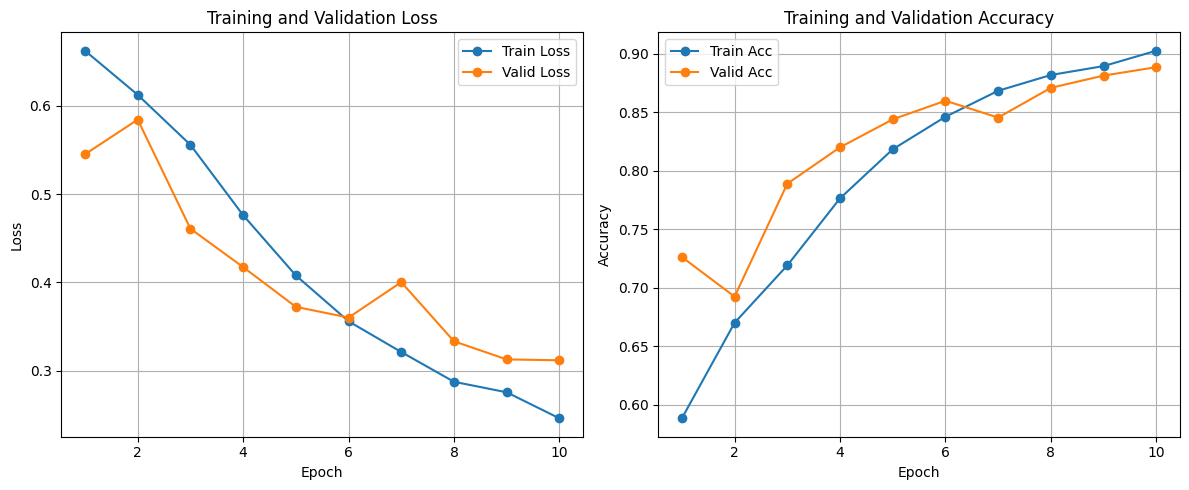

✅ 已加载最佳模型参数：lstm_best_model.pt


/tmp/ipykernel_31/1697626246.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.save_path))


In [46]:
trainer = Trainer(model, device, optimizer, criterion, save_path="lstm_best_model.pt", patience=3)
trainer.fit(train_loader, test_loader, num_epochs=num_epochs)

# 训练完成后加载最佳模型
trainer.load_best_model()

## 推理

In [47]:
from nltk.tokenize import word_tokenize
import torch.nn.functional as F

def predict_sentiment(text, model, word2idx, device):
    model.eval()

    # -------- 1. 分词 --------
    tokens = word_tokenize(text.lower())

    # -------- 2. 转ID --------
    unk_id = word2idx.get("<UNK>", 1)
    pad_id = word2idx.get("<PAD>", 0)
    ids = [word2idx.get(token, unk_id) for token in tokens]

    # -------- 3. 构造张量并送入模型 --------
    seq_length = torch.LongTensor([len(ids)])
    ids_tensor = torch.LongTensor([ids])  # batch_size=1

    ids_tensor = ids_tensor.to(device)
    seq_length = seq_length.to(device)

    with torch.no_grad():
        logits = model(ids_tensor, seq_length)
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=1).item()
        confidence = probs[0][pred].item()

    label_map = {0: "Negative", 1: "Positive"}
    return label_map[pred], confidence


In [48]:
# 确保模型加载了最佳参数
trainer.load_best_model()

# 推理样本
text = "This movie was absolutely wonderful! I loved every part of it."

# 预测
label, confidence = predict_sentiment(text, trainer.model, word2idx, device)

print(f"预测情感: {label}，置信度: {confidence:.2%}")


✅ 已加载最佳模型参数：lstm_best_model.pt
预测情感: Positive，置信度: 99.69%


/tmp/ipykernel_31/1697626246.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.save_path))


# Step 4 提升效果

## 加入attention机制

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class SentimentRNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, 
                 num_layers=1, bidirectional=False, dropout=0.5, pad_idx=0):
        super(SentimentRNNWithAttention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional,
                            dropout=dropout if num_layers > 1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim

        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim

        # Attention 层
        self.attn = nn.Linear(lstm_output_dim, 1, bias=False)
        
        # 输出层
        self.fc = nn.Linear(lstm_output_dim, output_dim)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))  # [B, L, E]
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)  # [B, L, H]

        # Attention score: [B, L, 1]
        attn_weights = self.attn(output)
        attn_weights = attn_weights.squeeze(2)  # [B, L]

        # mask: 避免注意力关注到 <PAD> 位置
        mask = torch.arange(output.size(1), device=lengths.device)[None, :] < lengths[:, None]
        attn_weights[~mask] = float('-inf')  # 屏蔽掉 padding

        attn_weights = F.softmax(attn_weights, dim=1)  # [B, L]

        # 加权求和：output 是 [B, L, H]，attn_weights 是 [B, L]
        context = torch.bmm(attn_weights.unsqueeze(1), output).squeeze(1)  # [B, H]
        context = self.dropout(context)

        return self.fc(context)  # [B, output_dim]


In [56]:
# 构造模型
model = SentimentRNNWithAttention(vocab_size, embed_dim, hidden_dim, output_dim,
                     num_layers=num_layers, bidirectional=bidirectional,
                     dropout=dropout, pad_idx=pad_idx)

# 将模型移动到GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 对于分类任务
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 将损失函数也移动到GPU
criterion = criterion.to(device)

num_epochs = 10


Epoch 1/10


  Train Loss: 0.5759, Train Acc: 68.61%
  Valid Loss: 0.4523, Valid Acc: 79.17%
  ✅ 模型已保存（验证准确率提升）

Epoch 2/10


  Train Loss: 0.4197, Train Acc: 81.07%
  Valid Loss: 0.4632, Valid Acc: 82.02%
  ✅ 模型已保存（验证准确率提升）

Epoch 3/10


  Train Loss: 0.3327, Train Acc: 86.02%
  Valid Loss: 0.3280, Valid Acc: 87.31%
  ✅ 模型已保存（验证准确率提升）

Epoch 4/10


  Train Loss: 0.2905, Train Acc: 88.02%
  Valid Loss: 0.3018, Valid Acc: 88.46%
  ✅ 模型已保存（验证准确率提升）

Epoch 5/10


  Train Loss: 0.2484, Train Acc: 90.09%
  Valid Loss: 0.2983, Valid Acc: 88.85%
  ✅ 模型已保存（验证准确率提升）

Epoch 6/10


  Train Loss: 0.2254, Train Acc: 91.08%
  Valid Loss: 0.3065, Valid Acc: 89.22%
  ✅ 模型已保存（验证准确率提升）

Epoch 7/10


  Train Loss: 0.2013, Train Acc: 92.10%
  Valid Loss: 0.3426, Valid Acc: 88.94%
  ⚠️ 验证准确率未提升 (counter=1/3)

Epoch 8/10


  Train Loss: 0.1931, Train Acc: 92.50%
  Valid Loss: 0.3249, Valid Acc: 89.34%
  ✅ 模型已保存（验证准确率提升）

Epoch 9/10


  Train Loss: 0.1694, Train Acc: 93.55%
  Valid Loss: 0.3475, Valid Acc: 89.39%
  ✅ 模型已保存（验证准确率提升）

Epoch 10/10


  Train Loss: 0.1473, Train Acc: 94.34%
  Valid Loss: 0.3136, Valid Acc: 90.11%
  ✅ 模型已保存（验证准确率提升）

📈 绘制训练曲线中...


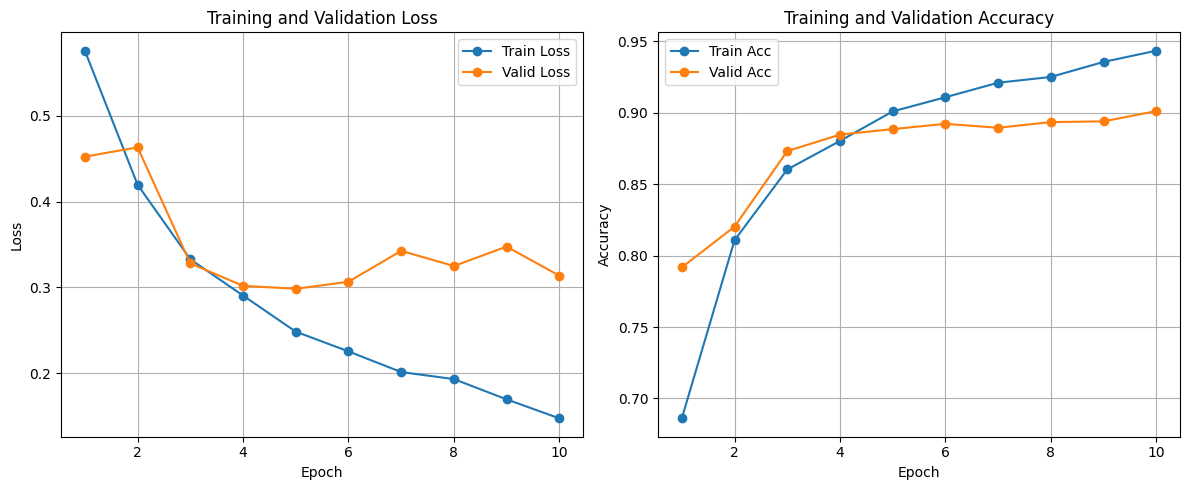

✅ 已加载最佳模型参数：lstm+attention_best_model.pt


/tmp/ipykernel_31/1697626246.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.save_path))


In [57]:
trainer = Trainer(model, device, optimizer, criterion, save_path="lstm+attention_best_model.pt", patience=3)
trainer.fit(train_loader, test_loader, num_epochs=num_epochs)

# 训练完成后加载最佳模型
trainer.load_best_model()

In [58]:
# 确保模型加载了最佳参数
trainer.load_best_model()

# 推理样本
text = "This movie was absolutely wonderful! I loved every part of it."

# 预测
label, confidence = predict_sentiment(text, trainer.model, word2idx, device)

print(f"预测情感: {label}，置信度: {confidence:.2%}")


✅ 已加载最佳模型参数：lstm+attention_best_model.pt
预测情感: Positive，置信度: 100.00%


/tmp/ipykernel_31/1697626246.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.save_path))


## 调参

In [59]:
embed_dim, hidden_dim, output_dim = 256, 128, 2
num_layers = 2
bidirectional = True
dropout = 0.5